# GEO877 Project    
**Authors:** *Alessandro Joshua Pierro 20-733-861, Alessandro Jud, Andreas Hvidt, Nina Moffat, Saskia Stierli*
**Date:** *2024-06-7*   
## Necessary Libraries

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

## Class Definitions

In [2]:
class Point():
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return f'Point(x={self.x:.2f}, y={self.y:.2f})'
    
    def distEuclidean(self, other):
        return np.sqrt((self.x-other.x)**2 + (self.y-other.y)**2)
    
    def __eq__(self, other): 
        if not isinstance(other, Point):
            return NotImplemented
        return self.x == other.x and self.y == other.y

class Segment():    
    def __init__(self, p0, p1):
        self.start = p0
        self.end = p1
        self.length = p0.distEuclidean(p1)
    
    def __repr__(self):
        return f'Segment with start {self.start} and end {self.end}.' 

class Bbox():    
    def __init__(self, data):
        if isinstance(data, Segment):
            x = [data.start.x, data.end.x]
            y = [data.start.y, data.end.y]
        else:      
            x = [i.x for i in data]
            y = [i.y for i in data]
        self.ll = Point(min(x), min(y))
        self.ur = Point(max(x), max(y))
        self.ctr = Point((max(x)-min(x))/2, (max(y)-min(y))/2)
        self.area = (abs(max(x)-min(x)))*abs((max(y)-min(y)))    
           
    def containsPoint(self, p):
        if (self.ur.x >= p.x and p.x >= self.ll.x and
            self.ur.y >= p.y and p.y >= self.ll.y):
            return True
        return False

    def intersects(self, other):       
        if (self.ur.x > other.ll.x and other.ur.x > self.ll.x and
            self.ur.y > other.ll.y and other.ur.y > self.ll.y):
            return True
        else:
            return False

class Polygon():  
    def __init__(self, data=None, xcol=None, ycol=None):
        self.points = []
        if isinstance(data[0], Point):
            self.points = data
        else:
            for d in data:
                self.points.append(Point(d[xcol], d[ycol]))
        self.size = len(self.points)
        self.bbox = Bbox(self.points)
        
    def __repr__(self):
        return f'Polygon PointGroup containing {self.size} points' 

    def get_points(self):
        return self.points
    
    def intersects(self, other):
        if not self.bbox.intersects(other.bbox):
            return False
        
        for i in range(len(self.points) - 1):
            for j in range(len(other.points) - 1):
                if self.segments_intersect(Segment(self.points[i], self.points[i + 1]), Segment(other.points[j], other.points[j + 1])):
                    return True
        return False
    
    def segments_intersect(self, seg1, seg2):
        def ccw(A, B, C):
            return (C.y - A.y) * (B.x - A.x) > (B.y - A.y) * (C.x - A.x)
        
        A, B = seg1.start, seg1.end
        C, D = seg2.start, seg2.end
        
        return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)
    
    def union(self, other):
        new_points = self.points[:-1] + other.points[:-1]
        new_polygon = Polygon(data=new_points, xcol=0, ycol=1)
        return new_polygon

## Algorithms   
### Buffer Algorithm

In [3]:
def calculate_normal_vector(start, end):
    """
    Calculates the normal vector parameters (i.e. coordinates the normal
    vector's end point would have when starting from the origin) for a 
    normal vector to a segment

    :attrib start:
        the starting point of the segment as
        point object from geospatial class
    :attrib seg2:
        the end point of the segment as
        point object from geospatial class
    :returns:
        the parameter values as a tuple
    """
    dx = end.x - start.x
    dy = end.y - start.y
    length = np.sqrt(dx**2 + dy**2)
    nx = -dy / length
    ny = dx / length
    return (nx, ny)

def buffer_segment(segment, buffer_distance, extension_distance = 0):
    """
    Generates a buffer polygon around a straight segment with a flat end.
    The end can be extended using the extension_distance.

    :attrib segment:
        segment to be buffered as segment object
        from geospatial class
    :attrib buffer_distance:
        the perpendicular distance to the segment
        by which the buffer should extend (in crs units)
    :attrib extension_distance:
        the distance, by which the flat end should extend
        from the ends of the segment (in crs units)
    :returns:
        the buffer as a Polygon object from geospatial class
    """
    # Calculate normal and parallel vector
    nx, ny = calculate_normal_vector(segment.start, segment.end)
    px, py = calculate_normal_vector(Point(0,0), Point(nx,ny))

    # Calculate buffer points
    buffer_ll = (segment.start.x + nx * buffer_distance, segment.start.y + ny * buffer_distance)
    buffer_ul = (segment.end.x + nx * buffer_distance, segment.end.y + ny * buffer_distance)
    buffer_ur = (segment.end.x - nx * buffer_distance, segment.end.y - ny * buffer_distance)
    buffer_lr = (segment.start.x - nx * buffer_distance, segment.start.y - ny * buffer_distance)
    
    # Extend the rectangle
    buffer_ll = (buffer_ll[0] + px * extension_distance, buffer_ll[1] + py * extension_distance)
    buffer_ul = (buffer_ul[0] - px * extension_distance, buffer_ul[1] - py * extension_distance)
    buffer_ur = (buffer_ur[0] - px * extension_distance, buffer_ur[1] - py * extension_distance)
    buffer_lr = (buffer_lr[0] + px * extension_distance, buffer_lr[1] + py * extension_distance)
    
    # Define clockwise ordered coordinates
    buffer_polygon = Polygon(data = [buffer_ll,buffer_ul,buffer_ur,buffer_lr, buffer_ll], xcol = 0, ycol = 1)
    
    return buffer_polygon

### Line Clipping using a polygon

In [ ]:
def dot(p0, p1):
    """
    Dot product function for the poly_line_clip function.

    :attrib p0:
        point with xy-coordinates as list or tuple
    :attrib p1:
        point with xy-coordinates as list or tuple
    :returns:
        dot product of the two points
    """
    return p0[0] * p1[0] + p0[1] * p1[1]


def poly_line_clip(polygon, segment):
    """
    Clips a segment using a polygon overlay. Note, that since the
    algorithm is unable to deal with lines, that are parallel to edges
    of the polygon, the result is slightly inaccurate by introducing an
    artificial offset of 0.0001 crs units to one of the segment points.

    :attrib polygon:
        Polygon object with which the segment should be
        clipped, needs to be ordered anticlockwise (not checked,
        will return false result if not adhered to)
    :attrib segment:
        Segment object that is to be clipped
    :returns:
        the clipped segment as Segment object from geospatial
        class
    """
    n = len(polygon.points)
    P1_P0 = (segment.end.x + 0.0001 - segment.start.x, segment.end.y - segment.start.y)
    normal = [(polygon.points[i].y - polygon.points[(i+1) % n].y, polygon.points[(i+1) % n].x - polygon.points[i].x) for i in range(n)]
    P0_PEi = [(polygon.points[i].x - segment.start.x, polygon.points[i].y - segment.start.y) for i in range(n)]
    numerator = [dot(normal[i], P0_PEi[i]) for i in range(n)]
    denominator = [dot(normal[i], P1_P0) for i in range(n)]
    t = [numerator[i] / denominator[i] if denominator[i] != 0 else 0 for i in range(n)]
    tE = [t[i] for i in range(n) if denominator[i] > 0]
    tL = [t[i] for i in range(n) if denominator[i] < 0]
    tE.append(0)
    tL.append(1)
    temp = [np.max(tE), np.min(tL)]
    if temp[0] > temp[1]:
        return None
    newSegment = Segment(Point(segment.start.x + P1_P0[0] * temp[0], segment.start.y + P1_P0[1] * temp[0]), 
               Point(segment.start.x + P1_P0[0] * temp[1], segment.start.y + P1_P0[1] * temp[1]))
    return newSegment

### Gridding

In [ ]:
def grid_segments(segment_list, gridbox_size):
    """
    Seperates segment data into grid-cells, using meters as
    gridbox size and squares as gridboxes.

    :attrib segment list:
        List of the segments to be separated into smaller
        "gridded" lists
    :attrib gridbox_size:
        Length and width of the square gridboxes in meters
    :returns:
        A list containing a list of segments for each gridbox
        and the clipping gridcells as a list of polygons
        (for visualization)
    """
    #initialize new segment list and grid polygons
    gridded_segments = []
    grid_polygons = []
    #get extent of data
    for i,segment in enumerate(segment_list):
        box = Bbox(segment)
        if i == 0:
            xmin,ymin,xmax,ymax = (box.ll.x,box.ll.y,box.ur.x,box.ur.y)
        else:
            if box.ll.x < xmin:
                xmin = box.ll.x
            if box.ll.y < ymin:
                ymin = box.ll.y
            if box.ur.x > xmax:
                xmax = box.ur.x
            if box.ur.y > ymax:
                ymax = box.ur.y
    x_extent = xmax-xmin
    y_extent = ymax-ymin
    #get gridcellcount in x&y dimension and set up polygons
    x_cellcount = int((x_extent // gridbox_size) +1)
    y_cellcount = int((y_extent // gridbox_size) +1)
    for i in range(y_cellcount):
        for j in range(x_cellcount):
            poly = Polygon([[(j*gridbox_size)+xmin,(i*gridbox_size)+ymin],
                            [((j+1)*gridbox_size)+xmin,(i*gridbox_size)+ymin],
                            [((j+1)*gridbox_size)+xmin,((i+1)*gridbox_size)+ymin],
                            [(j*gridbox_size)+xmin,((i+1)*gridbox_size)+ymin],
                            [(j*gridbox_size)+xmin,(i*gridbox_size)+ymin]
                            ],xcol=0,ycol=1)
            grid_polygons.append(poly)
    #cut segments with gridcells using cyrus-beck & add one segment-list per gridcell
    for cell in grid_polygons:
        grid_segments = []
        for segment in segment_list:
            if Bbox(segment).intersects(cell.bbox):
                clipped_segment = poly_line_clip(cell,segment)
                if clipped_segment is not None:
                    grid_segments.append(clipped_segment)
        gridded_segments.append(grid_segments)
    
    return gridded_segments, grid_polygons

### Polygon-Polygon intersection

In [ ]:
def poly_poly_intersection(poly1, poly2):
    """
    Returns the intersection between two polygons as new polygon.

    :attrib poly1:
        first Polygon object for the intersection, needs to 
        be ordered anticlockwise (not checked, will return 
        false result if not adhered to)
    :attrib poly2:
        second Polygon object for the intersection, needs to 
        be ordered anticlockwise (not checked, will return 
        false result if not adhered to)
    :returns:
        the intersection result as Polygon object
    """
    #check for bounding box overlap:
    if poly1.bbox.intersects(poly2.bbox) == False:
        return None
    
    #check if poly1 totally within poly2
    if poly2.containsPoint(poly1.points[0]):
        if all([poly2.containsPoint(point) for point in poly1.points]):
            return poly1
    
    #check if poly2 totally within poly1
    if poly1.containsPoint(poly2.points[0]):
        if all([poly1.containsPoint(point) for point in poly2.points]):
            return poly2

    #otherwise, start iterating over segments of poly1 to find intersection segments
    intersection_segments = []
    for i in range(len(poly1.points)-1):
        #create segments for each edge of poly 1
        seg = Segment(poly1.points[i], poly1.points[i+1])
        seg_int = poly_line_clip(poly2, seg)
        if seg_int is not None:
                intersection_segments.append(seg_int)      

    #extract vertices of intersection segments
    newpoly_vertices = []
    for edge in intersection_segments:
        newpoly_vertices.append([edge.start.x, edge.start.y])
    if len(intersection_segments) != 0:
        newpoly_vertices.append([intersection_segments[-1].end.x, intersection_segments[-1].end.y])
    
    # get all vertices of poly2 within poly1 (i.e. not on an intersection segment but
    # still part of the intersection polygon
    for i in range(len(poly2.points)-1):
         if poly1.containsPoint(poly2.points[i]):
              if [poly2.points[i].x, poly2.points[i].y] not in newpoly_vertices:
                newpoly_vertices.append([poly2.points[i].x, poly2.points[i].y])

    # append first point again to close polygon
    if len(intersection_segments) != 0:
        newpoly_vertices.append([intersection_segments[0].start.x,intersection_segments[0].start.y])
    
    #return none if intersection points is empty (bboxes overlap, but no intersections)
    if not newpoly_vertices:
        return None
    else:
        return Polygon(newpoly_vertices, xcol = 0, ycol = 1)

## Functions
### Functions to Load Data

In [4]:
def load_points_from_geojson(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    points = [Point(feature['geometry']['coordinates'][0], feature['geometry']['coordinates'][1])
              for feature in data['features']]
    return points

def load_segments_from_geojson(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    segments = []
    for feature in data['features']:
        coords = feature['geometry']['coordinates']
        if isinstance(coords[0], list):
            if isinstance(coords[0][0], list):
                for subcoords in coords:
                    for i in range(len(subcoords) - 1):
                        p1 = Point(subcoords[i][0], subcoords[i][1])
                        p2 = Point(subcoords[i + 1][0], subcoords[i + 1][1])
                        segments.append(Segment(p1, p2))
            else:
                for i in range(len(coords) - 1):
                    p1 = Point(coords[i][0], coords[i][1])
                    p2 = Point(coords[i + 1][0], coords[i + 1][1])
                    segments.append(Segment(p1, p2))
        else:
            p1 = Point(coords[0], coords[1])
            p2 = Point(coords[2], coords[3])
            segments.append(Segment(p1, p2))
    return segments

def load_polygons_from_geojson(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    polygons = []
    for feature in data['features']:
        coords = feature['geometry']['coordinates'][0]
        polygon_points = [[c[0], c[1]] for c in coords]
        polygons.append(Polygon(data=polygon_points, xcol=0, ycol=1))
    return polygons

### Function to Buffer the Segments

In [5]:
# Define buffer sizes based on previous discussions
buffer_size_motorways = 11  # meters
buffer_size_mainroads = 7.5  # example value, adjust as necessary
buffer_size_smallpaths = 2.5  # example value, adjust as necessary

def buffer_segments(segments, buffer_distance):
    buffered_segments = []
    for seg in segments:
        buffered_seg = buffer_segment(seg, buffer_distance)
        buffered_segments.append(buffered_seg)
    return buffered_segments

## Data Loading

In [6]:
# Set base data path (one level up from the current working directory)
base_data_path = "../data/geojson/"

# Define paths for Zurich and Graubunden, Swiss Topo and OSM data
zurich_swisstopo_path = base_data_path + "zurich/swisstopo/"
graubunden_swisstopo_path = base_data_path + "graubunden/swisstopo/"

zurich_osm_path = base_data_path + "zurich/osm/"
graubunden_osm_path = base_data_path + "graubunden/osm/"

# Load Swiss Topo geojsons for Zurich
motorway_zh_swisstopo_segments = load_segments_from_geojson(zurich_swisstopo_path + "motorway_zh_swisstopo.geojson")

mainroads_zh_swisstopo_segments = load_segments_from_geojson(zurich_swisstopo_path + "mainroads_zh_swisstopo.geojson")
smallpaths_zh_swisstopo_segments = load_segments_from_geojson(zurich_swisstopo_path + "smallpaths_zh_swisstopo.geojson")
print("Loaded Swiss Topo data for Zurich")

# Load Swiss Topo geojsons for Graubunden
motorway_gr_swisstopo_segments = load_segments_from_geojson(graubunden_swisstopo_path + "motorway_gr_swisstopo.geojson")
mainroads_gr_swisstopo_segments = load_segments_from_geojson(graubunden_swisstopo_path + "mainroads_gr_swisstopo.geojson")
smallpaths_gr_swisstopo_segments = load_segments_from_geojson(graubunden_swisstopo_path + "smallpaths_gr_swisstopo.geojson")
print("Loaded Swiss Topo data for Graubunden")

# Load OSM geojsons for Zurich
motorway_zh_osm_segments = load_segments_from_geojson(zurich_osm_path + "motorway_zh_osm.geojson")
mainroads_without_zh_osm_segments = load_segments_from_geojson(zurich_osm_path + "mainroads_without_zh_osm.geojson")
mainroads_with_zh_osm_segments = load_segments_from_geojson(zurich_osm_path + "mainroads_with_zh_osm.geojson")
smallpaths_without_zh_osm_segments = load_segments_from_geojson(zurich_osm_path + "smallpaths_without_zh_osm.geojson")
smallpaths_with_zh_osm_segments = load_segments_from_geojson(zurich_osm_path + "smallpaths_with_zh_osm.geojson")
print("Loaded OSM data for Zurich")

# Load OSM geojsons for Graubunden
motorway_gr_osm_segments = load_segments_from_geojson(graubunden_osm_path + "motorway_gr_osm.geojson")
mainroads_without_gr_osm_segments = load_segments_from_geojson(graubunden_osm_path + "mainroads_without_gr_osm.geojson")
mainroads_with_gr_osm_segments = load_segments_from_geojson(graubunden_osm_path + "mainroads_with_gr_osm.geojson")
smallpaths_without_gr_osm_segments = load_segments_from_geojson(graubunden_osm_path + "smallpaths_without_gr_osm.geojson")
smallpaths_with_gr_osm_segments = load_segments_from_geojson(graubunden_osm_path + "smallpaths_with_gr_osm.geojson")
print("Loaded OSM data for Graubunden")

Loaded Swiss Topo data for Zurich
Loaded Swiss Topo data for Graubunden
Loaded OSM data for Zurich
Loaded OSM data for Graubunden


## Data Processing
### Buffering the Segments

In [7]:
# Buffer the segments for Zurich and Graubunden
buffered_motorway_zh_swisstopo = buffer_segments(motorway_zh_swisstopo_segments, buffer_size_motorways)

buffered_mainroads_zh_swisstopo = buffer_segments(mainroads_zh_swisstopo_segments, buffer_size_mainroads)
buffered_smallpaths_zh_swisstopo = buffer_segments(smallpaths_zh_swisstopo_segments, buffer_size_smallpaths)
print("Buffered Swiss Topo segments for Zurich")

buffered_motorway_zh_osm = buffer_segments(motorway_zh_osm_segments, buffer_size_motorways)
buffered_mainroads_zh_osm = buffer_segments(mainroads_with_zh_osm_segments, buffer_size_mainroads)
buffered_smallpaths_zh_osm = buffer_segments(smallpaths_with_zh_osm_segments, buffer_size_smallpaths)
print("Buffered OSM segments for Zurich")

buffered_motorway_gr_swisstopo = buffer_segments(motorway_gr_swisstopo_segments, buffer_size_motorways)
buffered_mainroads_gr_swisstopo = buffer_segments(mainroads_gr_swisstopo_segments, buffer_size_mainroads)
buffered_smallpaths_gr_swisstopo = buffer_segments(smallpaths_gr_swisstopo_segments, buffer_size_smallpaths)
print("Buffered Swiss Topo segments for Graubunden")

buffered_motorway_gr_osm = buffer_segments(motorway_gr_osm_segments, buffer_size_motorways)
buffered_mainroads_gr_osm = buffer_segments(mainroads_with_gr_osm_segments, buffer_size_mainroads)
buffered_smallpaths_gr_osm = buffer_segments(smallpaths_with_gr_osm_segments, buffer_size_smallpaths)
print("Buffered OSM segments for Graubunden")

print("Buffered all segments")


Buffered Swiss Topo segments for Zurich
Buffered OSM segments for Zurich
Buffered Swiss Topo segments for Graubunden
Buffered OSM segments for Graubunden
Buffered all segments


In [8]:
print(type(buffered_motorway_zh_swisstopo))

<class 'list'>


Test if it works:

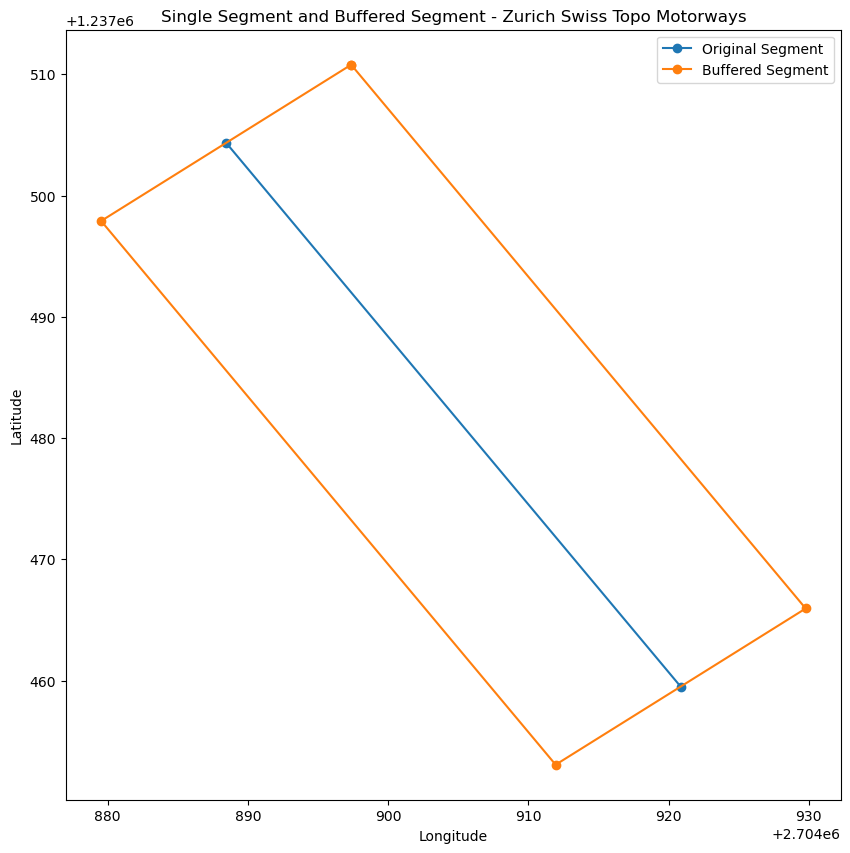

In [9]:
import matplotlib.pyplot as plt

# Function to plot a single segment and its buffered polygon in the same plot
def plot_segment_and_buffer(segment, buffered_segment, title):
    plt.figure(figsize=(10, 10))
    
    # Plot the original segment
    x_segment = [segment.start.x, segment.end.x]
    y_segment = [segment.start.y, segment.end.y]
    plt.plot(x_segment, y_segment, marker='o', label='Original Segment')
    
    # Plot the buffered polygon
    x_buffer = [point.x for point in buffered_segment.get_points()]
    y_buffer = [point.y for point in buffered_segment.get_points()]
    plt.plot(x_buffer, y_buffer, marker='o', label='Buffered Segment')
    
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

# Select a single segment from Zurich Swiss Topo motorways
single_segment = motorway_zh_swisstopo_segments[1020]


# Buffer the single segment
buffered_single_segment = buffer_segment(single_segment, buffer_size_motorways)


# Plot the single segment and its buffer
plot_segment_and_buffer(single_segment, buffered_single_segment, 'Single Segment and Buffered Segment - Zurich Swiss Topo Motorways')


In [10]:
def find_intersections(poly1_coords, poly2_coords):
    intersections = []
    for i in range(len(poly1_coords) - 1):
        for j in range(len(poly2_coords) - 1):
            p1 = poly1_coords[i]
            p2 = poly1_coords[i + 1]
            q1 = poly2_coords[j]
            q2 = poly2_coords[j + 1]
            intersect_point = segment_intersection(p1, p2, q1, q2)
            if intersect_point:
                intersections.append((p1, p2, q1, q2, intersect_point))
    return intersections

def segment_intersection(p1, p2, q1, q2):
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

    def intersect(A, B, C, D):
        return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

    if intersect(p1, p2, q1, q2):
        A1, B1 = p2[1] - p1[1], p1[0] - p2[0]
        C1 = A1 * p1[0] + B1 * p1[1]
        A2, B2 = q2[1] - q1[1], q1[0] - q2[0]
        C2 = A2 * q1[0] + B2 * q1[1]
        det = A1 * B2 - A2 * B1
        if det != 0:
            x = (B2 * C1 - B1 * C2) / det
            y = (A1 * C2 - A2 * C1) / det
            return [x, y]
    return None

def insert_intersections(poly_coords, intersections):
    new_coords = []
    for i in range(len(poly_coords) - 1):
        new_coords.append(poly_coords[i])
        for intersection in intersections:
            if poly_coords[i] in intersection and poly_coords[i + 1] in intersection:
                new_coords.append(intersection[4])
    new_coords.append(poly_coords[-1])
    return new_coords



In [11]:
def point_in_polygon(point, polygon_coords):
    x, y = point
    n = len(polygon_coords)
    inside = False
    px, py = polygon_coords[0]
    for i in range(1, n + 1):
        cx, cy = polygon_coords[i % n]
        if y > min(py, cy):
            if y <= max(py, cy):
                if x <= max(px, cx):
                    if py != cy:
                        xinters = (y - py) * (cx - px) / (cy - py) + px
                    if px == cx or x <= xinters:
                        inside = not inside
        px, py = cx, cy
    return inside

In [12]:
def point_on_segment(p, q1, q2):
    """Check if point p lies on segment q1q2."""
    if min(q1[0], q2[0]) <= p[0] <= max(q1[0], q2[0]) and min(q1[1], q2[1]) <= p[1] <= max(q1[1], q2[1]):
        if (q2[0] - q1[0]) * (p[1] - q1[1]) == (q2[1] - q1[1]) * (p[0] - q1[0]):
            return True
    return False

In [13]:
def close_polygon(coords):
    if coords[0] != coords[-1]:
        coords.append(coords[0])

def edge_function(poly1_coords, poly2_coords):
    #check if any point of poly 1 lies on an edge of poly2
    p1_on_p2 = False
    for point in poly1_coords:
        for i in range(len(poly2_coords) - 1):
            if point_on_segment(point, poly2_coords[i], poly2_coords[i + 1]):
                p1_on_p2 = True
                break
    #Chek if any point of poly 2 lies on an edge of poly1
    p2_on_p1 = False
    for point in poly2_coords:
        for i in range(len(poly1_coords) - 1):
            if point_on_segment(point, poly1_coords[i], poly1_coords[i + 1]):
                p2_on_p1 = True
                break
    if p1_on_p2 or p2_on_p1:
        return True
    
    return False

def polygons_overlap(poly1_coords, poly2_coords):
    # Check if any vertex of poly1 is inside poly2
    for point in poly1_coords:
        if point_in_polygon(point, poly2_coords):
            return True

    #Check if any vertex of poly2 is inside poly1
    for point in poly2_coords:
        if point_in_polygon(point, poly1_coords):
            return True

    #Check if any edge of poly1 intersects with any edge of poly2
    for i in range(len(poly1_coords) - 1):
        for j in range(len(poly2_coords) - 1):
            p1 = poly1_coords[i]
            p2 = poly1_coords[i + 1]
            q1 = poly2_coords[j]
            q2 = poly2_coords[j + 1]
            if segment_intersection(p1, p2, q1, q2):
                return True

    return False

def assemble_merged_polygon(poly1_coords, poly2_coords, intersections):
    poly1_coords = insert_intersections(poly1_coords, intersections)
    poly2_coords = insert_intersections(poly2_coords, intersections)
    close_polygon(poly1_coords)
    close_polygon(poly2_coords)

    # function to switch between the two polygons
    def switch_poly(poly):
        return poly2_coords if poly == poly1_coords else poly1_coords
    
    # function to get the index of a point in a polygon
    def get_current_index(poly,point):
        return poly.index(point)

    # function to get the next point in a polygon
    def get_next_point(poly,index):
        return poly[(index + 1) % len(poly)]   

    merged_polygon = [] # the merged polygon
    visited_intersections = set() # the set of visited intersections

    # start with the first intersection
    visited_intersections.add(tuple(intersections[0][4]))
    merged_polygon.append(intersections[0][4])

    list_intersections = [i[4] for i in intersections]
    # define the current polygon and the index of the current intersection for the current polygon
    current_poly = poly1_coords
    current_index = get_current_index(current_poly,intersections[0][4])
    current_point = current_poly[current_index]
    next_point_current= get_next_point(current_poly,current_index)
   
    while not next_point_current==intersections[0][4]:
        next_point_current= get_next_point(current_poly,current_index)
        

        if next_point_current in list_intersections and current_point in list_intersections:
            current_poly = switch_poly(current_poly)
            current_index = get_current_index(current_poly,current_point)
            next_point_current = get_next_point(current_poly,current_index)
            merged_polygon.append(next_point_current)
            current_point = next_point_current
            current_index = get_current_index(current_poly,current_point)
        elif next_point_current in list_intersections:
            merged_polygon.append(next_point_current)
            current_poly = switch_poly(current_poly)
            current_index = get_current_index(current_poly,next_point_current)
            current_point = next_point_current
            next_point_current = get_next_point(current_poly,current_index)
        elif point_in_polygon(next_point_current,switch_poly(current_poly)):
            current_poly = switch_poly(current_poly)
            current_index = get_current_index(current_poly,current_point)
            next_point_current = get_next_point(current_poly,current_index)
            merged_polygon.append(next_point_current)

        else:
            merged_polygon.append(next_point_current)
            current_index = get_current_index(current_poly,next_point_current)
            current_point = next_point_current
            next_point_current = get_next_point(current_poly,current_index)
    
    print(merged_polygon)
    return merged_polygon

def union(poly1, poly2):
    poly1_coords = [[i.x, i.y] for i in poly1.points]
    poly2_coords = [[i.x, i.y] for i in poly2.points]

    intersections = find_intersections(poly1_coords, poly2_coords)
    merged_coords = assemble_merged_polygon(poly1_coords, poly2_coords, intersections)
    close_polygon(merged_coords)
    return Polygon([list(coord) for coord in merged_coords], 0, 1)

In [14]:
def merge_polygons(buffered_segments):
    merged_polygons = buffered_segments
    
    total_polygons = len(merged_polygons)
    merged_count = 0
    
    for poly1 in merged_polygons:
        print("New Poly 1")
        for poly2 in merged_polygons:
            print("New Poly 2")
            poly1_coords = [[i.x, i.y] for i in poly1.points]
            poly2_coords = [[i.x, i.y] for i in poly2.points]
            if poly1 == poly2:
                print("Same polygon")
                continue
            print(poly1_coords)
            print(poly2_coords)
            if edge_function(poly1_coords, poly2_coords):
                if polygons_overlap(poly1_coords, poly2_coords):
                    # add 0.0001 to the coordinates of poly2
                    poly2_coords = [[i[0] + 0.0001, i[1] + 0.0001] for i in poly2_coords]
                    poly2 = Polygon(poly2_coords, 0, 1)
                    unioned = union(poly1, poly2)
                    merged_polygons[merge_polygons == poly1] = unioned
                    merged_polygons.remove(poly2)
                    #poly2 = poly2_new
                    merged_count += 1
                    poly1 = unioned
                    print(f"Polygons merged: {merged_count}, Polygons left: {total_polygons - merged_count}")
                continue
            elif polygons_overlap(poly1_coords, poly2_coords):
                unioned = union(poly1, poly2)
                merged_polygons[merge_polygons == poly1] = unioned
                merged_polygons.remove(poly2)
                merged_count += 1
                poly1 = unioned
                print(f"Polygons merged: {merged_count}, Polygons left: {total_polygons - merged_count}")
    
    return merged_polygons


In [15]:
test = merge_polygons(buffered_motorway_zh_swisstopo)

New Poly 1
New Poly 2
Same polygon
New Poly 2
[[2675701.000217317, 1236046.927423282], [2675702.2502173167, 1236048.541423285], [2675719.6437827665, 1236035.07057027], [2675718.393782767, 1236033.4565702672], [2675701.000217317, 1236046.927423282]]
[[2675702.870554051, 1236049.2739965203], [2675704.797554052, 1236051.3579965162], [2675720.9504460334, 1236036.4219970305], [2675719.0234460323, 1236034.3379970347], [2675702.870554051, 1236049.2739965203]]
[[2675710.947000047, 1236041.8059967752], [2675702.870554051, 1236049.2739965203], [2675702.870554051, 1236049.2739965203], [2675704.797554052, 1236051.3579965162], [2675720.9504460334, 1236036.4219970305], [2675719.349612024, 1236034.6907370037], [2675718.393782767, 1236033.4565702672], [2675701.000217317, 1236046.927423282], [2675702.2502173167, 1236048.541423285]]
Polygons merged: 1, Polygons left: 23804
New Poly 2
[[2675710.947000047, 1236041.8059967752], [2675702.870554051, 1236049.2739965203], [2675702.870554051, 1236049.2739965203

KeyboardInterrupt: 

In [ ]:
poly1 = Polygon([[2675701.000217317, 1236046.927423282], [2675702.2502173167, 1236048.541423285], [2675714.310865077, 1236039.2007729323], [2675715.1805161573, 1236038.5272513414], [2675719.6437827665, 1236035.07057027], [2675718.393782767, 1236033.4565702672], [2675711.1169802644, 1236039.0922599263], [2675715.270614084, 1236035.8753811999], [2675701.000217317, 1236046.927423282]], 0, 1)
poly2 = Polygon([[2675693.4163432936, 1236031.212484637], [2675693.1693432922, 1236038.4824846361], [2675714.310865077, 1236039.2007729323], [2675711.1169802644, 1236039.0922599263], [2675715.1566567873, 1236039.2295089092], [2675715.1805161573, 1236038.5272513414], [2675715.270614084, 1236035.8753811999], [2675715.4036567886, 1236031.95950891], [2675693.4163432936, 1236031.212484637]], 0, 1)

plt.plot([i.x for i in poly1.points], [i.y for i in poly1.points], 'r-')
plt.plot([i.x for i in poly2.points], [i.y for i in poly2.points], 'b-')
plt.show()